[8.6495073e-01 4.3800000e-04 4.4168000e-04]
[-1.05488617e-02 -1.36419228e+03]


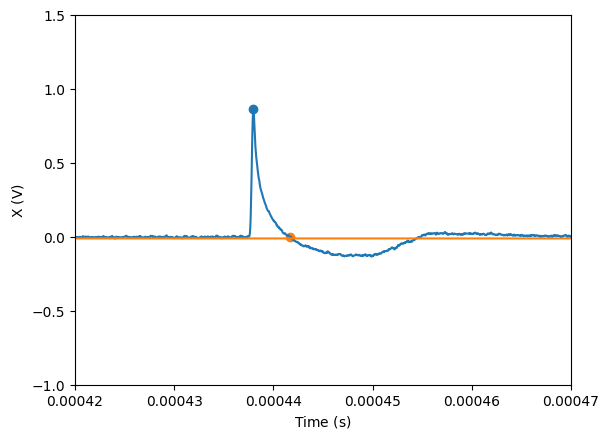

In [27]:
# importing necessary packages for data analysis.
import numpy as np
import sys
sys.path.append("../../lhillber/brownian/src")
from time_series import CollectionTDMS as ctdms
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# data from 07/17 Sagnac/Sagnac_fire_19J is complete shit
# we need to retake this data and make sure that the signal is being 
# taken correctly. For now, I'm using the data from 07/14 because it
# is a better representation of what our data should look like.
d = "../data/20230801/Sagnac/iter_0.tdms"
laser = ctdms(d)
micro = ctdms(d)
laser.set_collection("X")
laser.apply("detrend", mode = "linear", inplace = True)
laser.apply("calibrate", cal = -1, inplace = True)
micro.set_collection("Y")
fig, ax = plt.subplots()

shot = laser.collection[3]
shot.plot(tmin = 4.2e-4, tmax = 4.7e-4, ax = ax)
def friedlander(t, peak, tau):
    return peak * np.exp((-t / tau)) * (1 - (t / tau))

peak_index = np.where(shot.x == max(shot.x))[0][0]
z_crossing = peak_index + np.where(np.diff(np.sign(shot.x[peak_index:])))[0][0]
ax.scatter(shot.t[peak_index], shot.x[peak_index])
ax.scatter(shot.t[z_crossing], shot.x[z_crossing])
guess = np.array([shot.x[peak_index], shot.t[peak_index], shot.t[z_crossing]])
popt, pcov = curve_fit(friedlander, shot.t[peak_index : z_crossing + 500], shot.x[peak_index : z_crossing + 500], maxfev = 100000)
ax.plot(shot.t, friedlander(shot.t, *popt))
print(guess)
print(popt)
ax.set_xlim([4.2e-4, 4.7e-4])
ax.set_ylim([-1, 1.5])
plt.show()

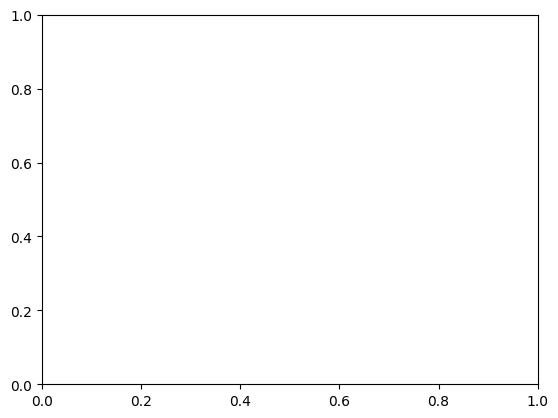

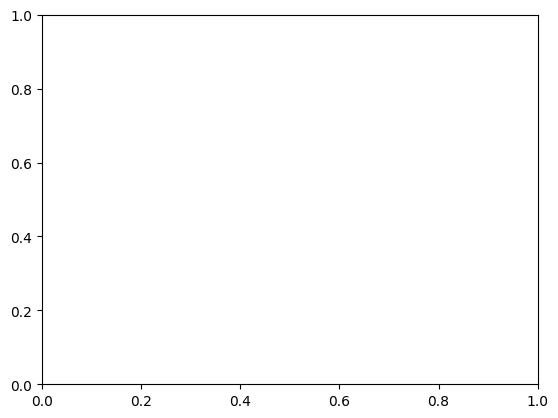

In [206]:
def SNR(data, freq_cutoffs, bin_avg, laser = True) -> []:
    snr = []
    for f in freq_cutoffs:
        col = ctdms(data)
        if laser:
            col.set_collection("X")
        else:
            col.set_collection("Y")
        peaks = np.array([])
        rms = np.array([])
        col.apply("detrend", mode = "linear", inplace = True)
        col.apply("lowpass", cutoff = f, inplace = True)
        if laser:
            col.apply("calibrate", cal = -1, inplace = True)
        else:
            col.apply("correct", response = mic_response, recollect = True)
        if bin_avg:
            N = col.r / (2 * f)
            col.apply("bin_average", Npts = N, inplace = True)
        for s in col.collection[1:]:
            peaks = np.append(peaks, max(s.time_gate(tmin = 4e-4, tmax = 5e-4)[1]))
            rms = np.append(rms, np.std(s.time_gate(tmin = 1.7e-4, tmax = 3.6e-4)[1]))
        snr.append(np.mean(peaks / rms))
    return snr
def SNRvsFreq(data, freqs, titles, bins = False, save_fig = False, fig_title = "defaul_SNR.png") -> []:
    import numpy as np
    import sys
    sys.path.append("../../lhillber/brownian/src")
    from time_series import CollectionTDMS as ctdms
    import matplotlib.pyplot as plt
    from acoustic_entrainment import mic_response
    
    if save_fig:
        fig, ax = plt.subplots()
    snrs = []
    for i in range(len(titles)):
        if titles[i][:3] == "mic":
            snrs.append(SNR(data[i], freqs[i], bins, False))
        else:
            snrs.append(SNR(data[i], freqs[i], bins))
        if save_fig:
            ax.plot(freqs[i], snrs[i], label = titles[i])
    if save_fig:
        ax.set_title("SNR vs frequency at 19J.")
        ax.set_xlabel("frequency")
        ax.set_ylabel("SNR")
        fig.legend()
        fig.savefig(fig_title)
        fig.close()
    return snrs

data = ["../data/20230801/Sagnac/iter_0.tdms", "../data/20230801/Sagnac/iter_0.tdms", "../data/20230801/SplitBeam/iter_0.tdms", "../data/20230801/Telescope/iter_0.tdms"]
max_power_titles = ["sagnac", "microphone", "split", "telescope"]
freqs = [np.linspace(10000, 3000000, 50) for i in range(len(max_power_titles))]
# max_power = SNRvsFreq(data, freqs, max_power_titles)
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
min_detect_systems = ["../data/20230801/Sagnac/MinDetect/", "../data/20230801/Sagnac/MinDetect/", "../data/20230801/SplitBeam/MinDetect/", "../data/20230801/Telescope/MinDetect/"]
data = [m + p for m in min_detect_systems for p in phis]
titles = [t + " " + p[:-5] for t in max_power_titles for p in phis]
freqs = [np.linspace(10000, 2000000, 50) for i in range(len(data))]
s = SNRvsFreq(data, freqs, titles)
s_with_bins = SNRvsFreq(data, freqs, titles, bins = True)

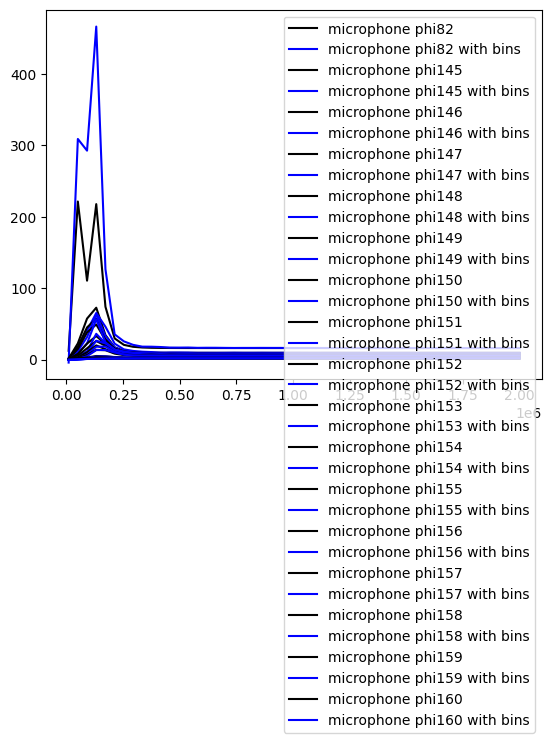

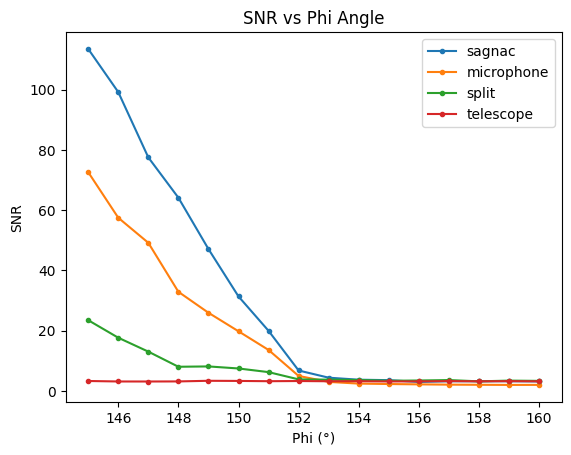

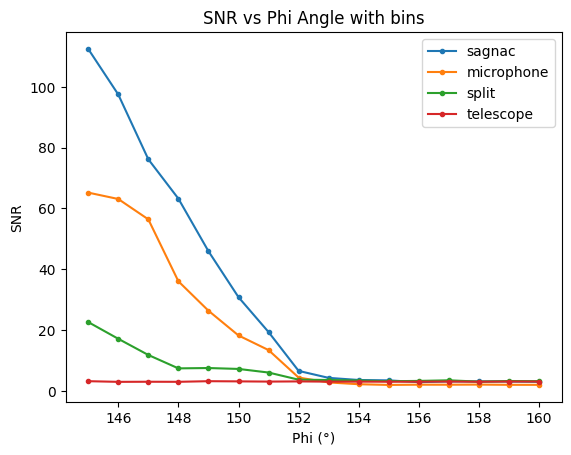

In [210]:
fig, ax = plt.subplots()
for i in range(17, 34):
    ax.plot(freqs[i], s[i], c = "k", label = titles[i])
    ax.plot(freqs[i], s_with_bins[i], c = "b", label = titles[i] + " with bins")
plt.legend()
plt.show()

ind = [np.where(i == max(i))[0][0] for i in s]
phi = np.append(82, np.linspace(145, 160, 16))
snr = [[] for i in max_power_titles]
max_freq_snr = [[] for i in max_power_titles]
for i in range(len(ind)):
    snr[int(i / len(phi))].append(s[i][ind[i]])
    max_freq_snr[int(i / len(phi))].append(freqs[i][ind[i]])
fig, ax = plt.subplots()
for i in range(len(max_power_titles)):
    plt.plot(phi[1:], snr[i][1:], ".-", label = max_power_titles[i])
plt.title("SNR vs Phi Angle")
plt.ylabel("SNR")
plt.xlabel("Phi (°)")
plt.legend()
plt.savefig("SNRvsPhiWithoutBins.png")
plt.show()

ind = [np.where(i == max(i))[0][0] for i in s_with_bins]
phi = np.append(82, np.linspace(145, 160, 16))
snr = [[] for i in max_power_titles]
max_freq_snr = [[] for i in max_power_titles]
for i in range(len(ind)):
    snr[int(i / len(phi))].append(s_with_bins[i][ind[i]])
    max_freq_snr[int(i / len(phi))].append(freqs[i][ind[i]])
fig, ax = plt.subplots()
for i in range(len(max_power_titles)):
    plt.plot(phi[1:], snr[i][1:], ".-", label = max_power_titles[i])
plt.title("SNR vs Phi Angle with bins")
plt.ylabel("SNR")
plt.xlabel("Phi (°)")
plt.legend()
plt.savefig("SNRvsPhiWithBins.png")
plt.show()